# import

In [1]:
import os
import sys
import math
import pandas as pd
import numpy as np
import matplotlib as mpl
import Orange

In [2]:
from config import *

sys.path.append(os.path.normpath('../../src'))
from experiment import AGG
from common import count_false_alarm, load_record, load_record_md3
from util import fix_plot

In [3]:
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\\usepackage{sansmath}\n\\sansmath'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# Functions

In [4]:
def make_mean_std(df, target, datasets, detectors):
    df_mean = df.groupby(by=['dataset', 'method']).mean()[target].unstack()[detectors].T[datasets]
    df_std = df.groupby(by=['dataset', 'method']).std()[target].unstack()[detectors].T[datasets]
    return df_mean, df_std

In [5]:
def make_rank(df, target, detectors, ascending=False):
    df = df.pivot_table(index=['dataset', 'seed'], columns=['method'], values=target)
    df = df[detectors].T
    df = df.rank(method='average', ascending=ascending).T[detectors]
    return df

In [6]:
def make_wdl(df, detector, is_loss):
    if is_loss:
        sign = np.sign(df.T - df[detector].values).T
    else:
        sign = -np.sign(df.T - df[detector].values).T
    win = (sign == 1).sum()
    draw = (sign == 0).sum()
    loss = (sign == -1).sum()
    return pd.DataFrame([win, draw, loss], index=['Win', 'Draw', 'Loss']).T

In [7]:
def make_wdl_ratio(df, detectors, target, is_loss):
    df_tmp = df.pivot_table(index=['dataset', 'seed'], columns='method', values=target)[detectors]
    wdls = dict()
    for i in detectors:
        wdl = make_wdl(df_tmp, i, is_loss)
        wdls[i] = wdl.drop(i).sum()
    df_wdl = pd.DataFrame(wdls)
    df_wdl = (df_wdl / df_wdl.sum().values).T
    return df_wdl.sort_values('Win', ascending=False)

In [8]:
def make_wdl_table(df, detectors, target, is_loss):
    df_tmp = df.pivot_table(index=['dataset', 'seed'], columns='method', values=target)[detectors]
    wdls = list()
    for i in detectors:
        wdl = make_wdl(df_tmp, i, is_loss)
        wdls.append(wdl.apply(lambda row: '/'.join(row.values.astype(str)), axis=1))
    df_wdl = pd.DataFrame(wdls, index=detectors)
    return df_wdl

In [9]:
def make_legend(df, ax):
    types = [DETECTOR_TYPES[method] for method in df.index]
    types = sorted(set(types), key=types.index)
    
    ax.get_shared_x_axes().remove(ax)
    ax.get_shared_y_axes().remove(ax)
    ax.xaxis.major = mpl.axis.Ticker()
    ax.yaxis.major = mpl.axis.Ticker()
    ax.xaxis.set_major_locator(mpl.ticker.AutoLocator())
    ax.yaxis.set_major_locator(mpl.ticker.AutoLocator())

    bars = [ax.bar(i, 0, color=COLORS[t]) for i, t in enumerate(types)]
    ax.legend(bars, types, loc='center', bbox_to_anchor=(0.5, 0.5), frameon=False, handletextpad=0.2)
    ax.axis('off')

In [10]:
def plot_result_bar(m, s, nrows, ncols, ylabel, ylim=(None, None), save_path=None):
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*1.5), sharex=True, sharey=True)
    axes = axes.flatten()
    for i, col in enumerate(m.columns):
        ax = axes[i]
        m[col].plot.bar(yerr=s[col], ax=ax, color=[COLORS[DETECTOR_TYPES[method]] for method in m.index], width=0.8)
        ax.set_xlabel('')
        ax.set_ylabel(ylabel)
        ax.tick_params(axis='x', labelrotation=90)
        ax.tick_params(axis='y', direction='in')
        ax.text(0.98, 0.98, col.replace('_', '-'), horizontalalignment='right', verticalalignment='top',
                transform=ax.transAxes)

        if (i // ncols) < (nrows - 1):
            ax.xaxis.set_visible(False)
        else:
            ax.set_xticklabels(m.index.str.replace('_', '-'))

    ax.set_ylim(ylim)
    i = i + 1  # keep for legend
    make_legend(m, ax=axes[i])
    while(i + 1 < nrows * ncols):
        i += 1
        axes[i].remove()    
        
    fix_plot(plt, True, 0.08, 0.08, SAVE_TO_FILE, save_path, SAVE_EXT)

In [11]:
def plot_result_wdl_ratio(df_wdl_ratio, save_path=None):
    df_plt = df_wdl_ratio.copy()
    df_plt.index = df_plt.index.str.replace('_', '-')
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    df_plt.plot(ax=ax, kind='barh', stacked=True, width=0.8, xlim=(0, 1), color=['dodgerblue', '#f0f0ff', 'tomato'])
    ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False)
    ax.invert_yaxis()

    fix_plot(plt, True, 0, 0, SAVE_TO_FILE, save_path, SAVE_EXT)

In [12]:
def plt_score_base(ax, df, metric='mcc', skip=0.02):
    for idx, row in df.iterrows():
        _, _, _, _, _, score, drifts = load_record(row['record'])
        n_skip = int(score.index[-1] * skip)
#         ax.plot(score[metric][n_skip:], c='k', alpha=0.5, lw=1)
        ax.plot(score[metric][n_skip:], c='k', lw=0.5)
        y_min = min(score[metric][n_skip:])
        y_max = max(score[metric][n_skip:])
        for drift in drifts:
            y = score[metric][drift]
            # to avoid y-axis range becomes to wide
            if drift < score[metric][n_skip:].index[0]:
                y = np.clip(y, y_min, y_max)
            ax.scatter(drift, y, c='r', marker='|', s=50, zorder=3)

        cp = row['n_change_point']
        x_max = row['n_instances']

    ax.axvline(cp, c='k', ls=':')
    ax.set_xlim(0, x_max)
    ax.set_xlabel('instances')
    ax.set_ylabel('score')
    return ax

In [13]:
def plt_score_methods(df_base, methods, dataset, how_feature, metric='mcc', save_path=None):
    df = df_base.copy()
    df = df[df['how_feature'] == how_feature]
    df = df[df['dataset'] == dataset]

    ncols = 4
    nrows = math.ceil(len(methods) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*1.2), sharex=True, sharey=True)
    axes = axes.flatten()
    for i, method in enumerate(methods):
        ax = axes[i]
        df_tmp = df[df['method'] == method]
        ax = plt_score_base(ax, df_tmp, metric)
        ax.text(0.98, 0.95, method.replace('_', '-'), horizontalalignment='right', verticalalignment='top',
                transform=ax.transAxes)
        if (i // ncols) < (nrows - 1):
            ax.set_xlabel('')
        if (i % ncols) > 0:
            ax.set_ylabel('')
    while(i + 1 < nrows * ncols):
        i += 1
        axes[i].remove()

    fix_plot(plt, True, 0, 0, SAVE_TO_FILE, save_path, SAVE_EXT)

In [14]:
def plt_score_datasets(df_base, method, datasets, how_feature, metric='mcc', save_path=None):
    df = df_base.copy()
    df = df[df['how_feature'] == how_feature]
    df = df[df['method'] == method]

    ncols = 4
    nrows = math.ceil(len(datasets) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*1.2))
    axes = axes.flatten()
    for i, dataset in enumerate(datasets):
        ax = axes[i]
        df_tmp = df[df['dataset'] == dataset]
        ax = plt_score_base(ax, df_tmp, metric)
        ax.text(0.98, 0.95, dataset.replace('_', '-'), horizontalalignment='right', verticalalignment='top',
                transform=ax.transAxes)
        if (i // ncols) < (nrows - 1):
            ax.set_xlabel('')
        if (i % ncols) > 0:
            ax.set_ylabel('')
    while(i + 1 < nrows * ncols):
        i += 1
        axes[i].remove()

    fix_plot(plt, True, 0, 0.1, SAVE_TO_FILE, save_path, SAVE_EXT)

In [15]:
def plt_score_methods_datasets(df_base, methods, datasets, how_feature, metric='mcc', save_path=None):
    df = df_base.copy()
    df = df[df['how_feature'] == how_feature]

    ncols = len(methods)
    nrows = len(datasets)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*2), sharey='row')
    for i, dataset in enumerate(datasets):
        df_d = df[df['dataset'] == dataset]
        for j, method in enumerate(methods):
            ax = axes[i, j]
            df_dm = df_d[df_d['method'] == method]
            ax = plt_score_base(ax, df_dm, metric)
            ax.text(0.98, 0.95, dataset.replace('_', '-') + '-' + method.replace('_', '-'), horizontalalignment='right',
                    verticalalignment='top', transform=ax.transAxes)
            ax.tick_params(labelbottom=False)
            if i < (nrows - 1):
                ax.set_xlabel('')
            if j > 0:
                ax.set_ylabel('')

    fix_plot(plt, True, 0, 0, SAVE_TO_FILE, save_path, SAVE_EXT)

In [16]:
def plt_CD(df_rank, width=10, save_path=None):
    names = df_rank.columns.str.replace("_", "-")
    avranks = df_rank.mean()
    cd = Orange.evaluation.compute_CD(avranks, len(df_rank))

    if SAVE_TO_FILE and save_path:
        filename = save_path + SAVE_EXT
    else:
        filename = None
    Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=width, filename=filename)

In [43]:
def describe_results(detectors, target, is_loss, basename, score_fn, ylabel, ylim):
    save_path = os.path.join(OUTPUT_DIR, basename)
    df = score_fn(df_base, datasets, detectors, target, how_class='minor')
    df_mean, df_std = make_mean_std(df, target, datasets, detectors)
    plot_result_bar(df_mean, df_std, nrows, ncols, ylim=ylim, ylabel=ylabel, save_path=save_path)

#     df_wdl_ratio = make_wdl_ratio(df, detectors, target, is_loss)
#     plot_result_wdl_ratio(df_wdl_ratio, save_path=save_path + '_wdl')

    df_rank = make_rank(df, target, detectors, ascending=is_loss)
    plt_CD(df_rank, save_path=save_path + '_CD')

    if SAVE_TO_FILE:
        df_results = df_mean.T.applymap('{0:.3f}'.format) + ' ± ' + df_std.T.applymap('{0:.3f}'.format)
        df_results[list(ALL_USV_DETECTORS)].to_latex(os.path.join(OUTPUT_DIR, basename + '.txt'))
        if len([d for d in detectors if d in SV_DETECTORS]) > 0:
            df_results[list(SV_DETECTORS)].to_latex(os.path.join(OUTPUT_DIR, basename + '_acc.txt'))
#         df_wdl = make_wdl_table(df, detectors, target, is_loss)
#         df_wdl.to_latex(os.path.join(OUTPUT_DIR, basename + '_wdl.txt'))

# Results for paper

In [32]:
SAVE_TO_FILE = False
SAVE_EXT = '.eps'

In [19]:
n_tune = len(DATA_PRMS['seed']) // 2

In [20]:
dfs = []
for detector in ALL_DETECTORS:
    for dataset in DATASETS:
        agg = AGG(SAVE_DATA_DIR, dataset, detector)
        df = agg.select_results(**DETECTOR_PRMS[detector][dataset])
        df['dataset'] = dataset
        df['method'] = detector
        dfs.append(df)
df_base = pd.concat(dfs)
df_base = df_base[df_base['seed'] >= n_tune]

In [21]:
datasets = DATASETS
ncols = 4
nrows = (len(datasets) + ncols) // ncols

## Classification score

In [44]:
def make_clf_score(df_base, datasets, detectors, target, how_class):
    df = df_base.copy()
    df = df[df['how_feature'] == 'relevant']
    df = df[df['how_class'] == how_class]
    df = df[['dataset', 'seed', 'method', target]].reset_index(drop=True)
    return df

In [45]:
detectors = ALL_DETECTORS.keys()
describe_results(detectors, 'mcc', False, 'clf_score', make_clf_score, 'classification score', (0.4, 1))

## False alarm

In [46]:
def make_fa_score(df_base, datasets, detectors, target, how_class):
    df = df_base.copy()
    df = df[df['how_class'] == how_class]
    df = count_false_alarm(df)
    df = df[['dataset', 'seed', 'method', target]].reset_index(drop=True)
    return df

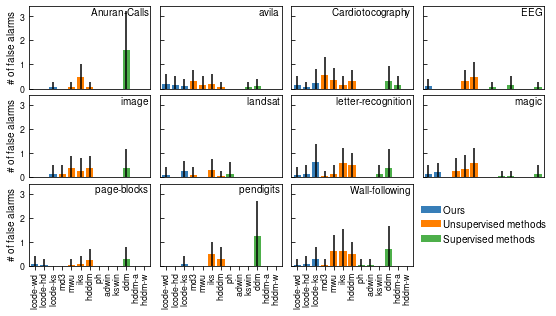

In [47]:
detectors = list(ALL_DETECTORS.keys())[:-2]
describe_results(detectors, 'false alarm', True, 'fa_score', make_fa_score, '\# of false alarms', (0, None))

## Delay

In [48]:
def make_delay_score(df_base, datasets, detectors, target, how_class):
    df = df_base.copy()
    df = df[df['how_feature'] == 'relevant']
    df = df[df['how_class'] == how_class]
    df = df[['dataset', 'method', 'seed', 'change_point', 'n_instances', 'n_change_point', 'drifts']].reset_index(drop=True)

    cp = df['n_change_point'].values
    cp = cp[:, np.newaxis]
    delay = pd.DataFrame(df['drifts'].apply(lambda x: list(x)).tolist()).values
    delay = delay - cp
    delay[delay <= 0] = np.nan
    delay = np.nanmin(delay, axis=1)
    delay /= df['n_instances'].values
    delay[np.isnan(delay)] = 1 - df['change_point'].values[np.isnan(delay)]
    df[target] = delay
    df = df[['dataset', 'method', 'seed', target]].reset_index(drop=True)
    return df

All-NaN slice encountered


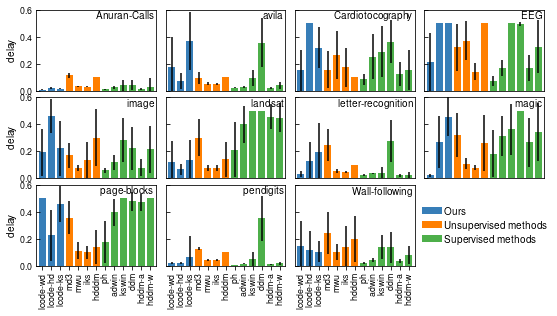

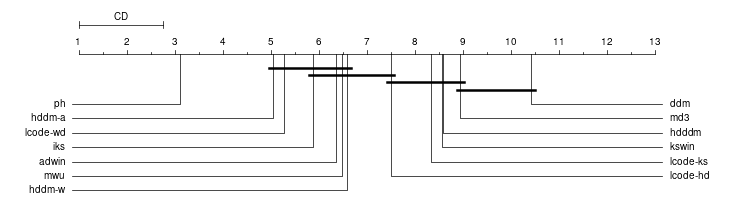

In [49]:
detectors = list(ALL_DETECTORS.keys())[:-2]
describe_results(detectors, 'delay', True, 'delay_score', make_delay_score, 'delay', (0, 0.6))

## Requested labels

In [50]:
def make_num_of_requested_label(df_base, datasets, detectors, target, how_class):
    df = df_base.copy()
    df = df[df['how_class'] == how_class]

    tmp = []
    for idx, row in df.iterrows():
        if row['method'] == 'md3':
            label_requests = load_record_md3(row['record'])
            tmp.append(label_requests)
        else:
            tmp.append(row['drifts'])
    
    df['drifts'] = tmp
    df = count_false_alarm(df)
    df = df[['dataset', 'method', 'seed', 'false alarm']].reset_index(drop=True)
    df.columns = ['dataset', 'method', 'seed', target]
    return df

In [51]:
detectors = ALL_USV_DETECTORS.keys()
describe_results(detectors, '\# of label requests', True, 'num_of_requests', make_num_of_requested_label, '\# of label requests', (0, None))

## Classification score over time


In [52]:
detectors = ALL_DETECTORS.keys()

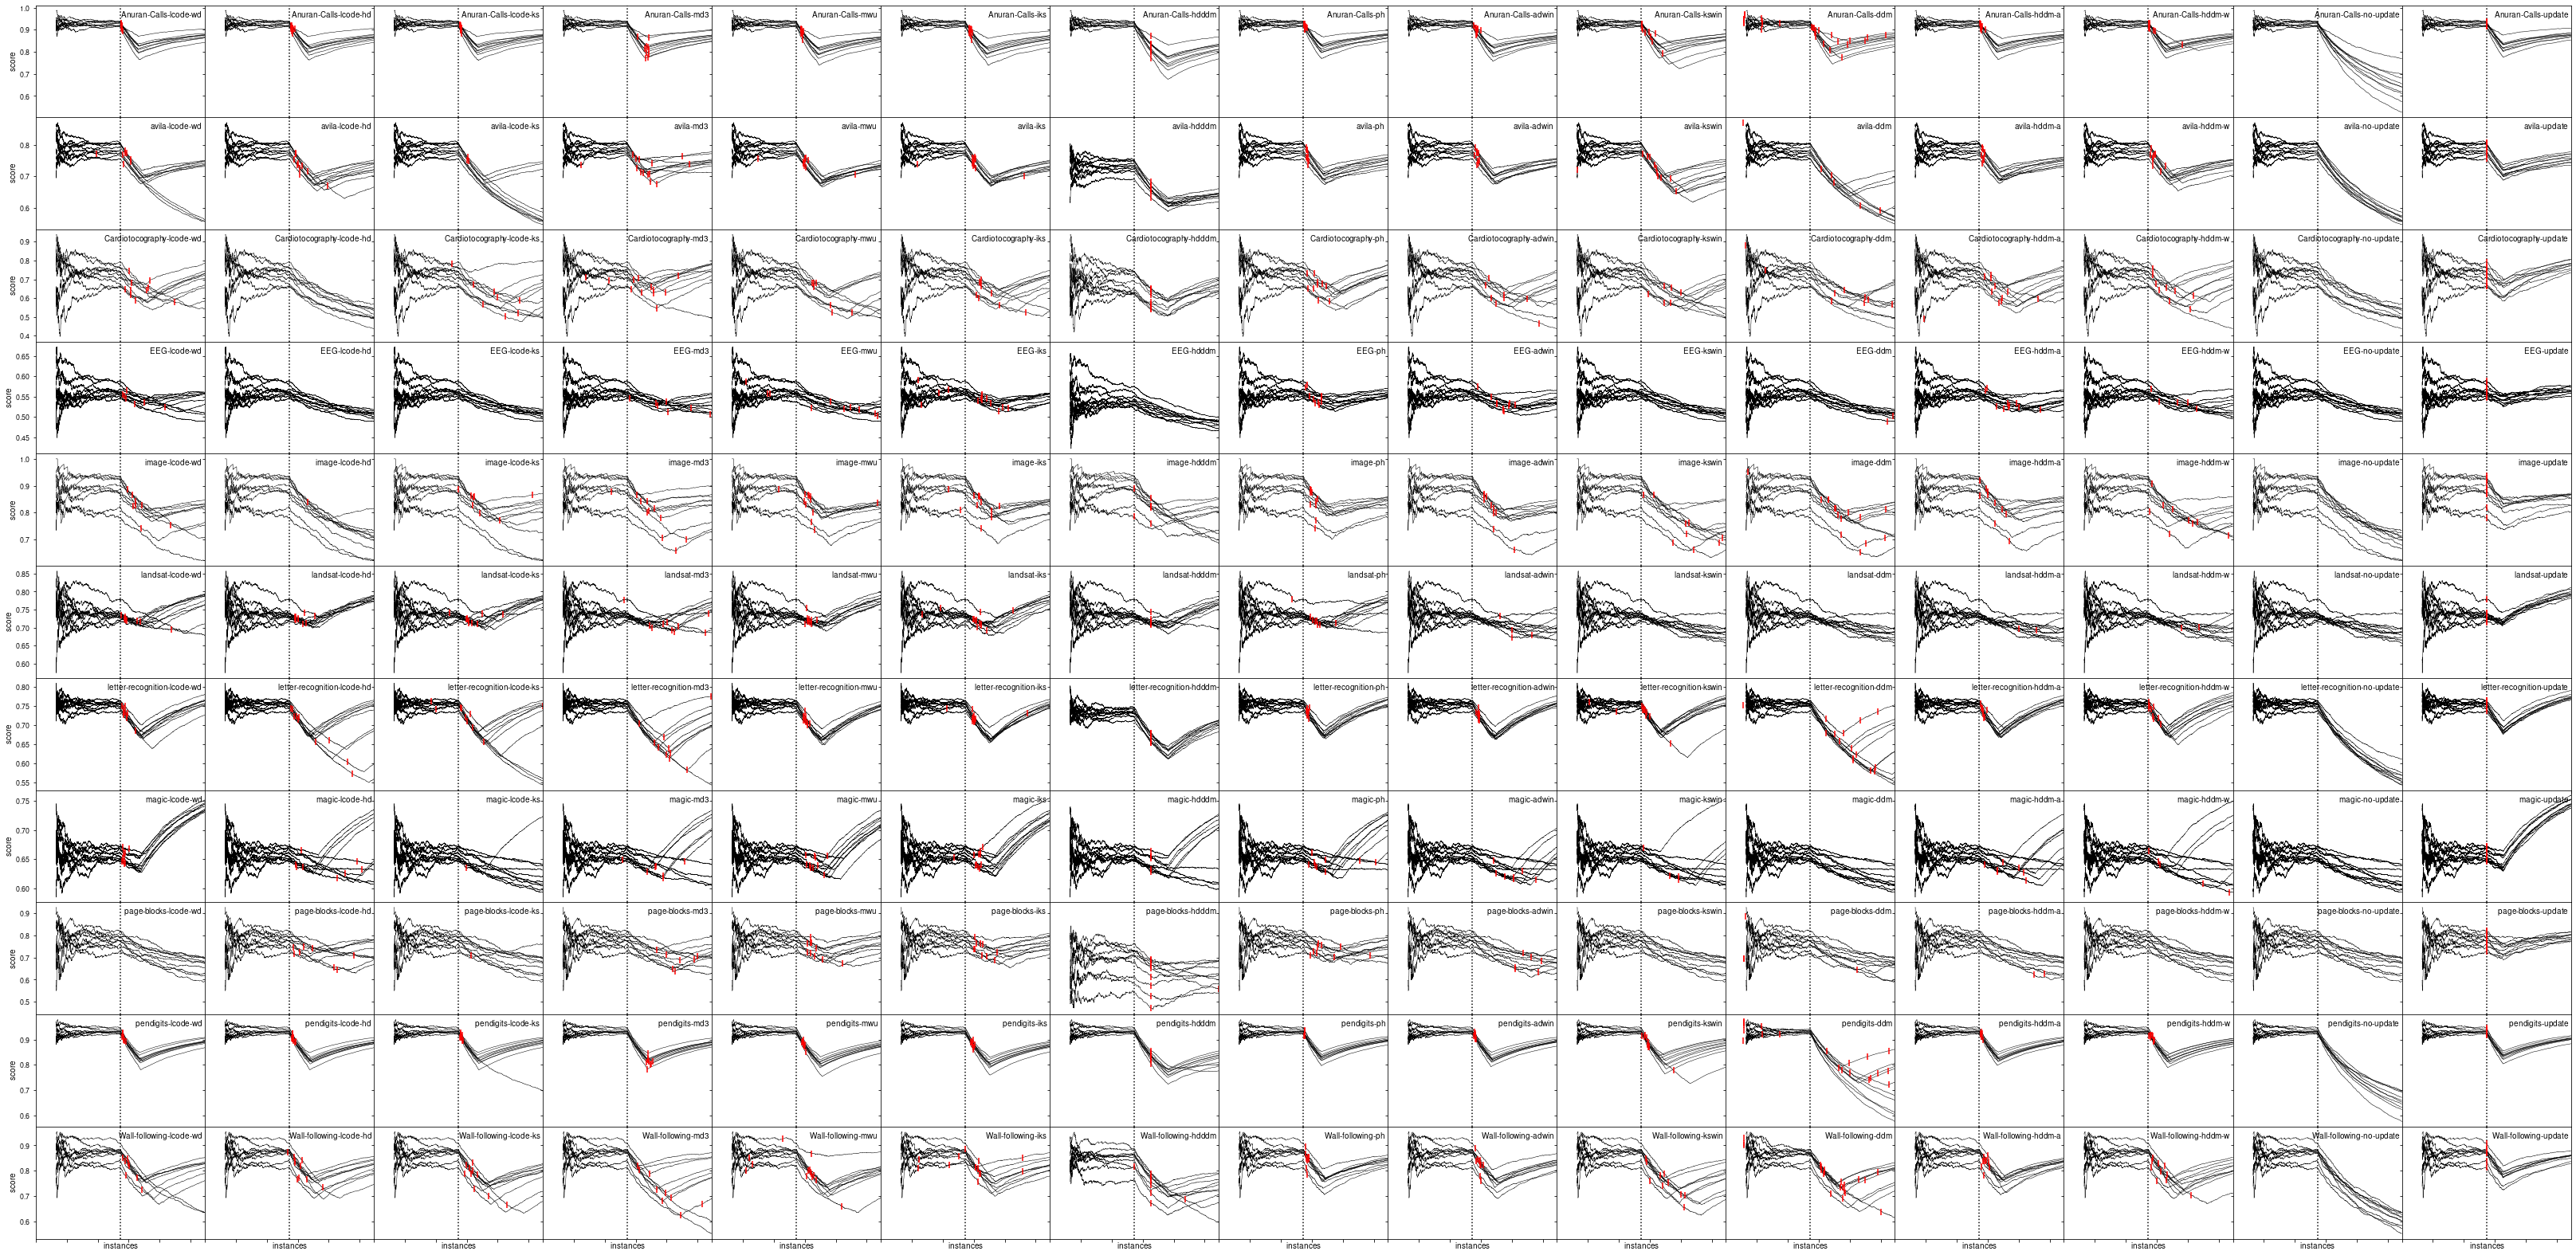

In [53]:
how_feature = 'relevant'
plt_score_methods_datasets(df_base, detectors, datasets, how_feature)

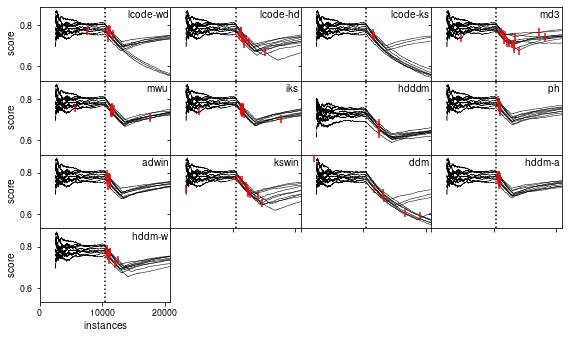

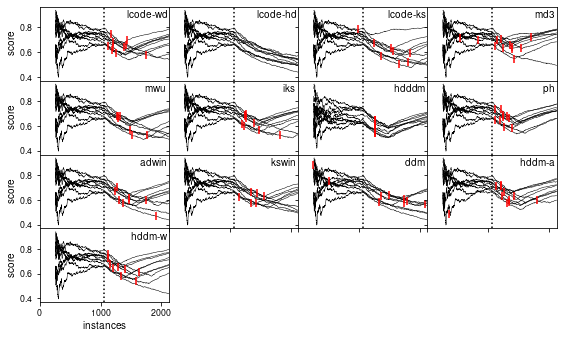

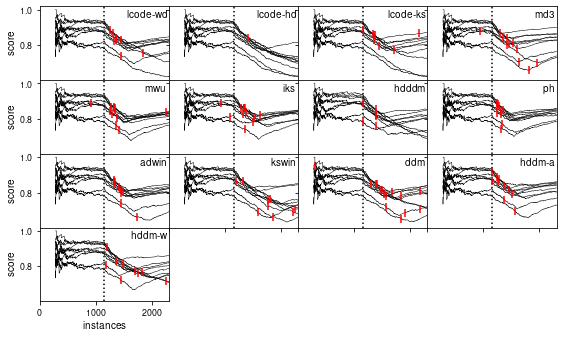

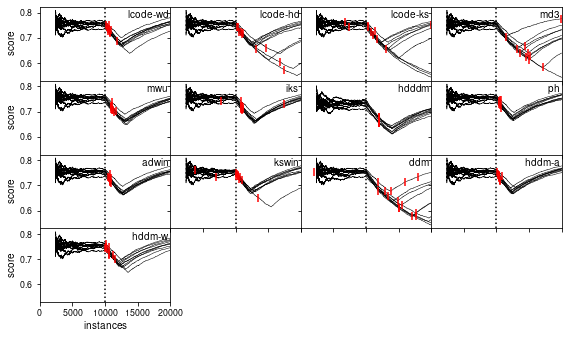

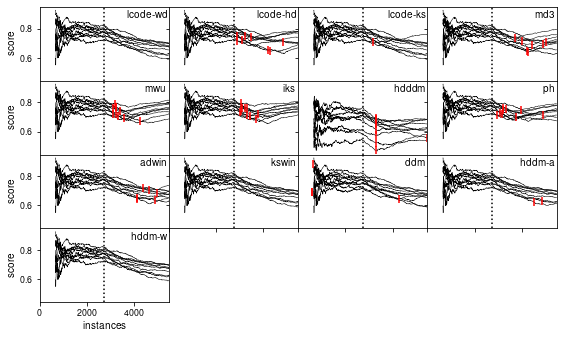

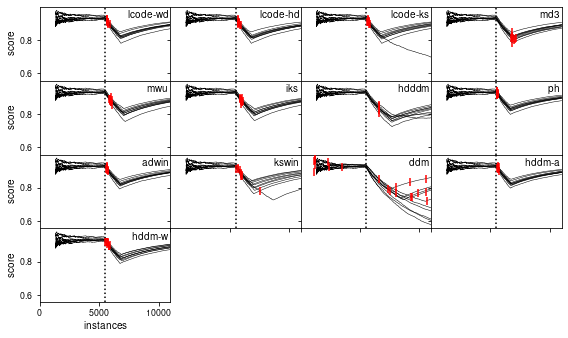

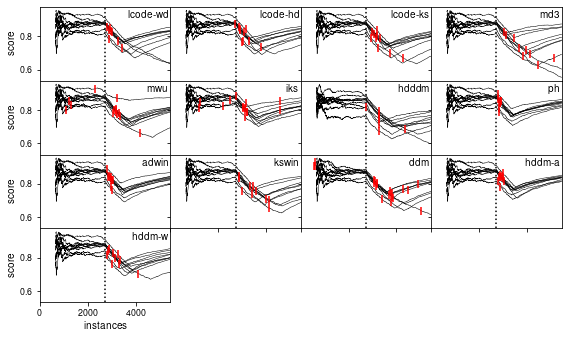

In [54]:
how_feature = 'relevant'
for dataset in datasets:
    save_path = os.path.join(OUTPUT_DIR, 'score_over_time_%s_%s' % (how_feature, dataset))
    plt_score_methods(df_base, list(detectors)[:-2], dataset, how_feature, save_path=save_path)

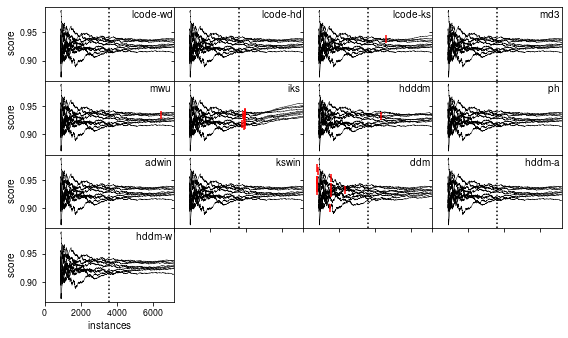

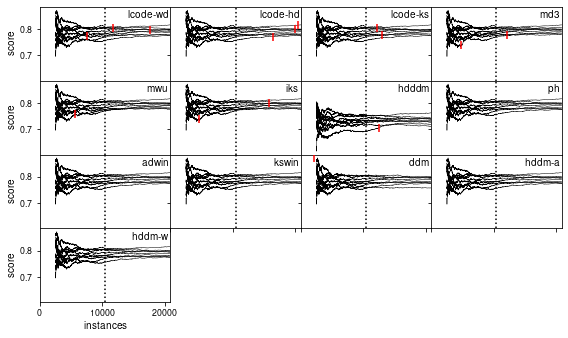

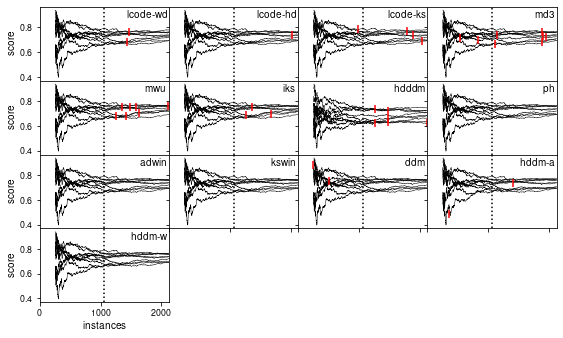

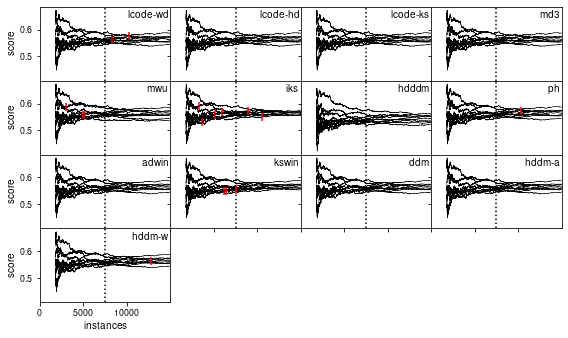

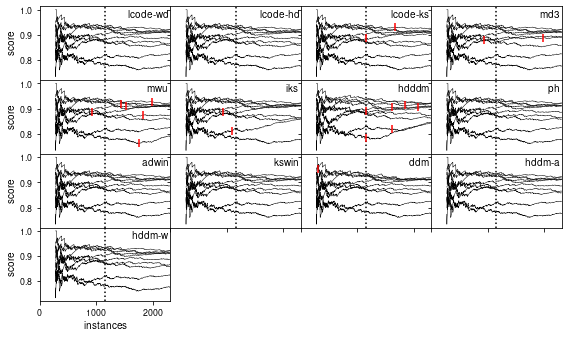

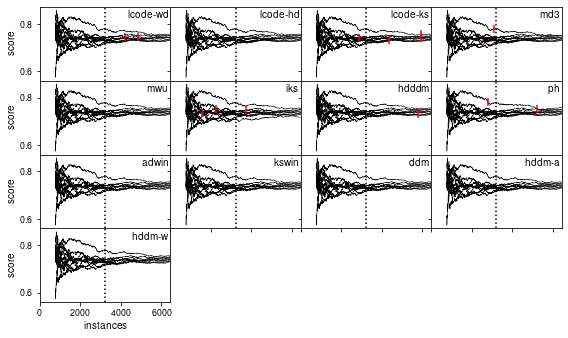

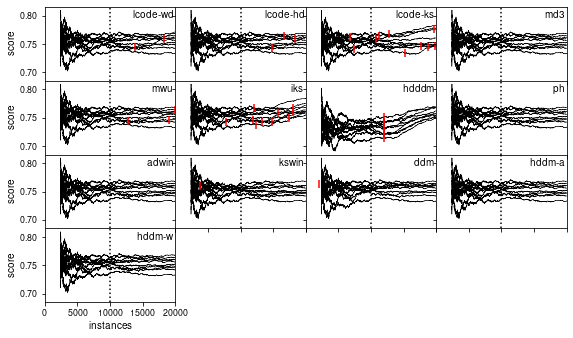

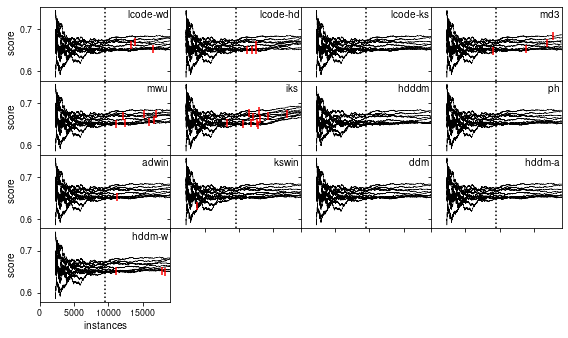

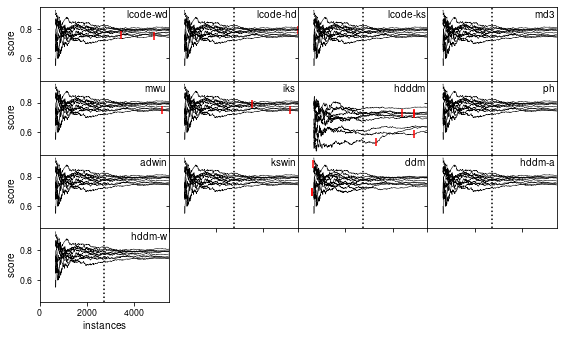

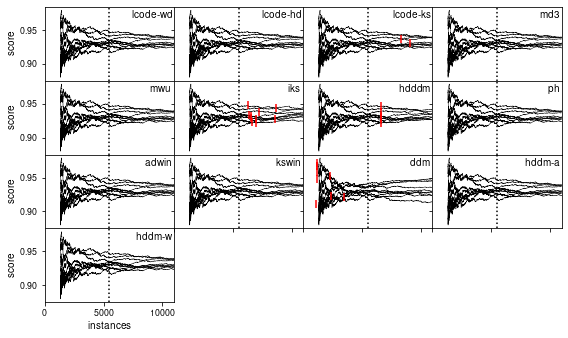

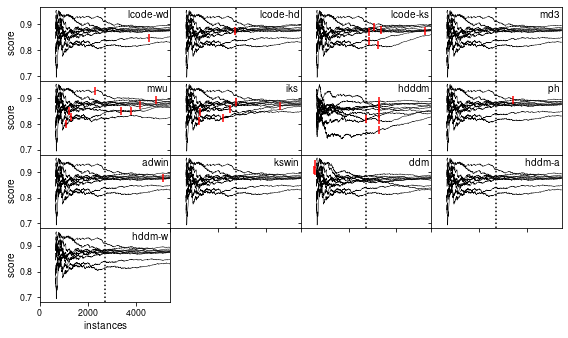

In [55]:
how_feature = 'irrelevant'
for dataset in datasets:
    save_path = os.path.join(OUTPUT_DIR, 'score_over_time_%s_%s' % (how_feature, dataset))
    plt_score_methods(df_base, list(detectors)[:-2], dataset, how_feature, save_path=save_path)

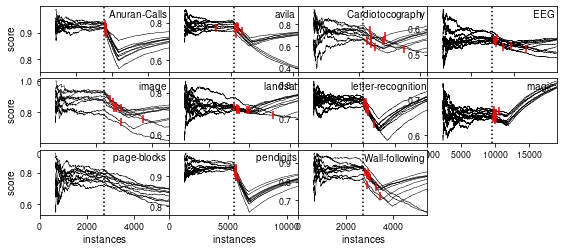

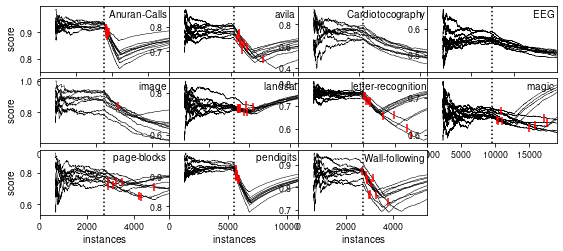

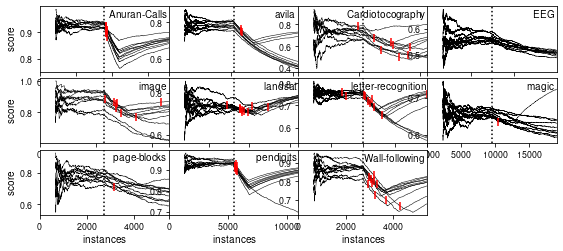

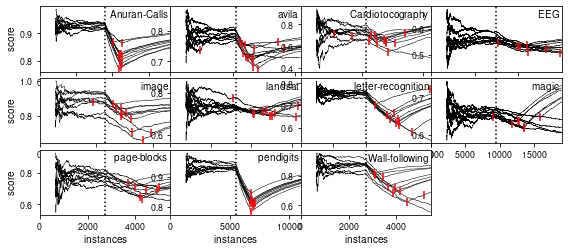

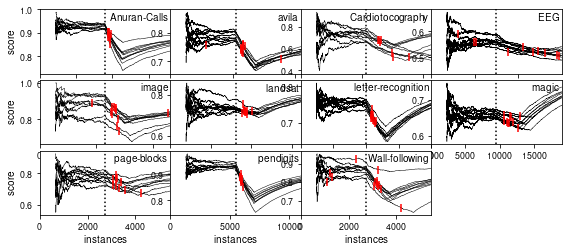

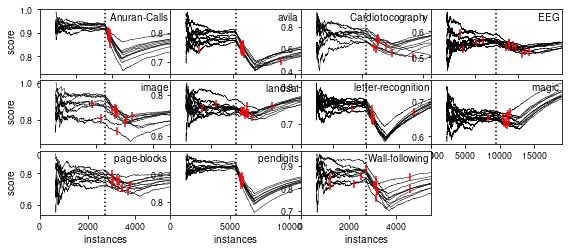

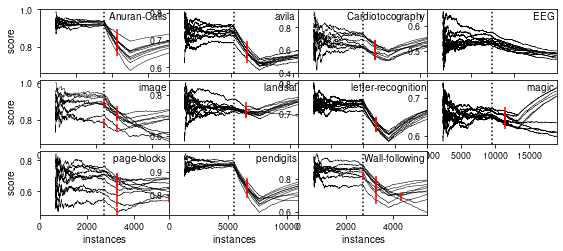

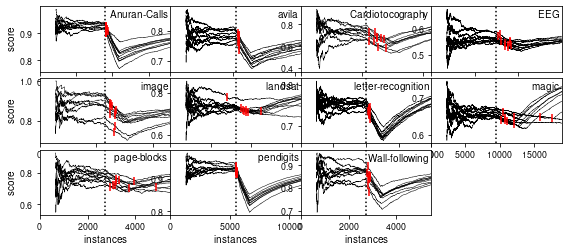

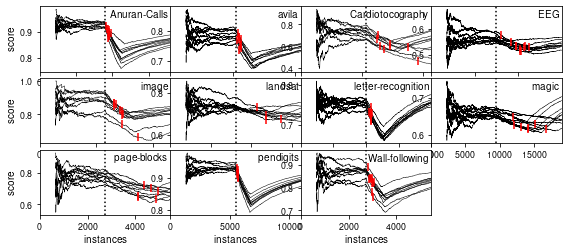

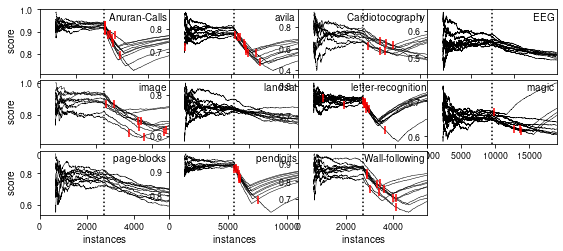

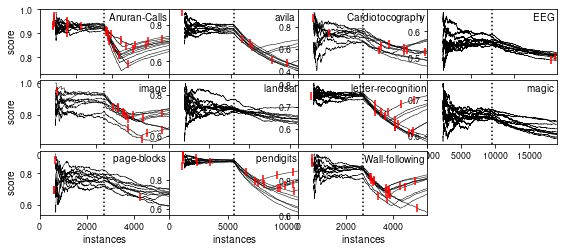

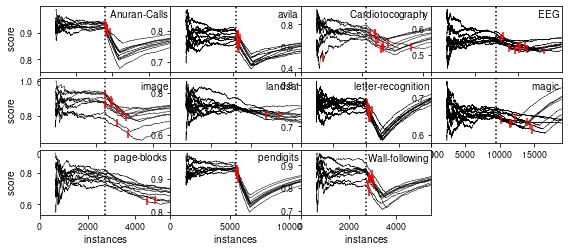

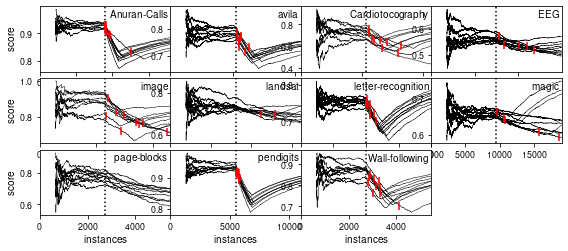

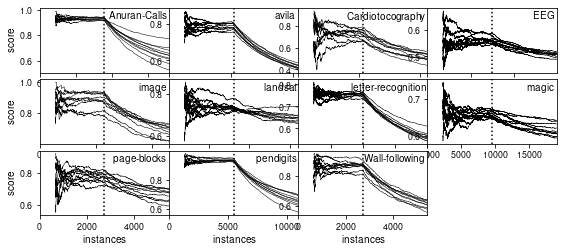

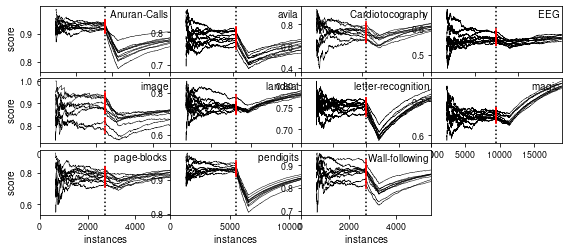

In [56]:
how_feature = 'relevant'
for detector in detectors:
    plt_score_datasets(df_base, detector, datasets, how_feature)